# Extra- and Intracellular Recordings of Crayfish Ganglia

## Step 1: Format Recording
In this first section, we reformat the raw recording into a fiff file, thereby making it compatible with the *mne-python* package. This will come in handy for preprocessing and analysis.

In [1]:
import neo
import numpy as np
from mne import create_info
from mne.io import RawArray

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
f = 'raw/17925005.abf'

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main body.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load recordings.
recordings, = neo.AxonIO(filename=f).read_block().segments
nerve, muscle = recordings.analogsignals

## Concatenate raw recordings.
data = np.hstack([np.asarray(nerve, dtype=np.float64)  * 1e-6, # uV --> V 
                  np.asarray(muscle, dtype=np.float64) * 1e-3  # mV --> V
                 ]).T

## Create info object.
sfreq = float(nerve.sampling_rate)
ch_names = ['nerve', 'muscle']
ch_types = 'bio'

info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

## Create Raw object.
raw = RawArray(data, info)

## Save Raw object.
raw.save('raw/lab03_raw.fif', overwrite=True, verbose=False)
print('Done.')

Creating RawArray with float64 data, n_channels=2, n_times=35230720
    Range : 0 ... 35230719 =      0.000 ...   704.614 secs
Ready.
Done.


## Step 2: Preprocess Recording
Next, we open the raw FIFF file and preform preprocessing. Preprocessing will consist of two steps:
1. **Filtering:** remove slow-frequency drifts and high-frequency noise. [Gonzalo Rey et al. (2015)](http://www.sciencedirect.com/science/article/pii/S0361923015000684) recommend a high- and low-pass of 300 and 3000 Hz, respectively, for the extracellular nerve recording.
2. **Cropping:** reduce the file to the first two minutes of recording. This is because signal attenuation occurs over time (i.e. peak amplitude diminishes as the nerve slowly escapes the suction of the electrode.

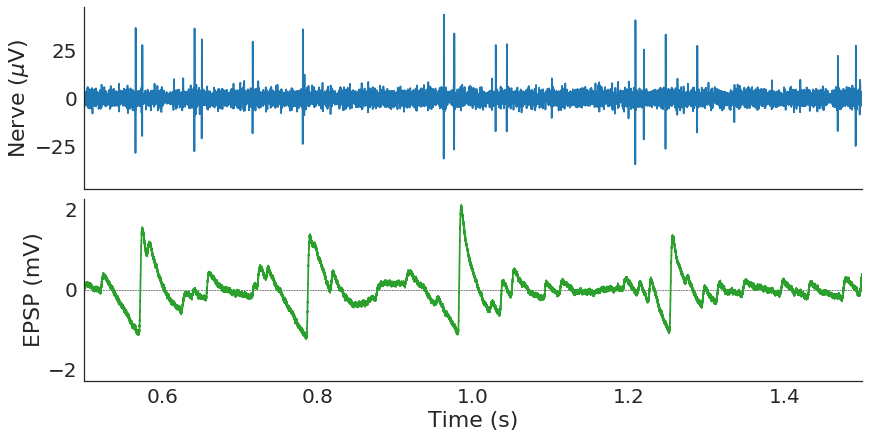

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mne import pick_channels
from mne.io import Raw
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
f = 'raw/lab03_raw.fif'

## Filter parameters (nerve).
filter_dict = dict( nerve = (300, 3000),
                    muscle = (10, None))

## Plotting parameters.
tmin = 0.5
tmax = 1.5

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load raw.
raw = Raw(f, preload=True, verbose=False)

## Filter data.
for ch_name in raw.ch_names:
    picks = pick_channels(raw.ch_names, include=[ch_name])
    raw = raw.filter(*filter_dict[ch_name], picks=picks, method='fir', phase='zero')

## Crop data.
raw = raw.crop(tmin=0, tmax=120)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(2,1,figsize=(12,6),sharex=True)

## Extract data.
data, times = raw.get_data(start=raw.time_as_index(tmin)[0], stop=raw.time_as_index(tmax)[0], return_times=True)

## Iteratively plot.
yscales = [1e6, 1e3]
ylabels = [r'Nerve ($\mu$V)', r'EPSP (mV)']
colors = ['#1f77b4', '#2ca02c']

for ax, arr, color, yscale, ylabel in zip(axes, data, colors, yscales, ylabels):

    ## Plot.
    ax.plot(times, arr * yscale, color=color)
    y = np.abs(ax.get_ylim()).max()
    ax.set(xlim=(tmin, tmax), ylim=(-y, y), ylabel=ylabel)
    ax.hlines(0, *ax.get_xlim(), linestyle='--', lw=0.5, zorder=0)
    
ax.set(xlabel='Time (s)')
sns.despine()
plt.subplots_adjust(left=0.05, right=0.95, top=0.99, hspace=0.05)

## Step 3: Peak Finding
From the plot above, it should be fairly obvious that the action potentials of the nerve align with the excitatory post-synaptic potentials (EPSPs) of the muscle fibers. To confirm this, we need to perform peak-detection. There are many viable peak-detection algorithms. We stick with a simple homebrew implementation of amplitude-thresholding. In this approach, contiguous sections of data above some positive threshold are identified; the maximum point for each cluster is returned as a peak. 

We define our threshold following [Quian-Quiroga et al. (2004)](http://www.mitpressjournals.org/doi/abs/10.1162/089976604774201631). The formula is straightforward: 

> $T = k \cdot \frac{median(|X|)}{0.6745} $

where the numberator is the median of the absolute value of the recording, $X$; the denominator is inverse of the cumulative distribution function for the standard normal distribution (see Quian-Quiroga et al., 2004); and $k$ is some constant (e.g. $k$=5). Below we motivate the choice of the constant, $k$, visualizing what percentage of the total data is beneath some threshold, $T$.

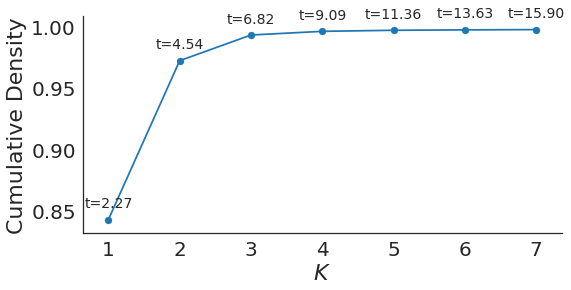

In [3]:
from peak_detection import *

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute thresholds.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Extract nerve data.
arr = raw.get_data(picks=pick_channels(raw.ch_names, ['nerve'])).squeeze()

## Compute cumulative density of data beneath threshold.
K = np.arange(1,8)
T = [find_threshold(arr, k) for k in K]
cdf = [(t > arr).mean() for t in T]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(K,cdf)
ax.scatter(K,cdf)
for k, y, t in zip(K, cdf, T): ax.text(k, y+1e-2, 't=%0.2f' %(t*1e6), ha='center', fontsize=14)
ax.set(xlabel=r'$K$', ylabel=r'Cumulative Density')
    
sns.despine()
plt.tight_layout()

As can be seen, $T=5$ is a fairly conservative threshold, greater than over 99% of the total data points in the raw recording. Below, we identify peaks using this threshold and additionally perform peak censoring [(Hill et al., 2011)](http://www.jneurosci.org/content/31/24/8699.short).

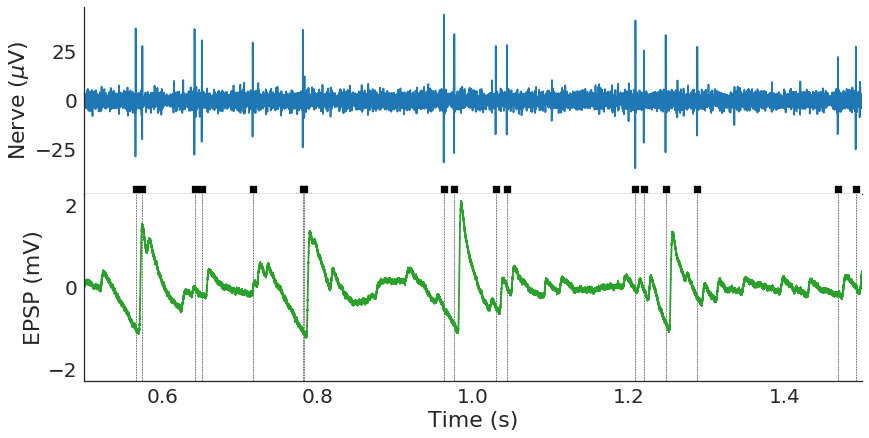

In [4]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Perform peak detection.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Extract nerve data.
arr = raw.get_data(picks=pick_channels(raw.ch_names, ['nerve'])).squeeze()

## Threshold.
k = 5
threshold = find_threshold(arr, k)

## Find peaks,
peak_loc, peak_mag = peak_finder(arr, threshold)

## Censor peaks.
peak_loc, peak_mag = peak_censor(raw.times, peak_loc, peak_mag, min_dist=2e-3)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(2,1,figsize=(12,6),sharex=True)

## Extract data.
data, times = raw.get_data(start=raw.time_as_index(tmin)[0], stop=raw.time_as_index(tmax)[0], return_times=True)

## Iteratively plot.
yscales = [1e6, 1e3]
ylabels = [r'Nerve ($\mu$V)', r'EPSP (mV)']
colors = ['#1f77b4', '#2ca02c']

for n, ax, arr, color, yscale, ylabel in zip(range(2), axes, data, colors, yscales, ylabels):

    ## Plot.
    ax.plot(times, arr * yscale, color=color)
    y = np.abs(ax.get_ylim()).max()
    ax.set(xlim=(tmin, tmax), ylim=(-y, y), ylabel=ylabel)
    
    ## Add peak information.
    if not n: ax.scatter(raw.times[peak_loc], np.ones_like(peak_loc)*-y*0.95, marker='s', color='k' )
    else: ax.vlines(raw.times[peak_loc], -y, y, linestyle='--', lw=0.5)
    
ax.set(xlabel='Time (s)')
sns.despine()
plt.subplots_adjust(left=0.05, right=0.95, top=0.99, hspace=0)

## Step 4: Spike Sorting

In [5]:
from mne import Epochs
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def zscore(arr): return (arr - arr.mean()) / arr.std()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Make epochs.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define events. 
events = np.vstack([peak_loc, np.zeros_like(peak_loc), np.ones_like(peak_loc)]).T
picks=pick_channels(raw.ch_names, ['nerve'])

## Make epochs.
epochs = Epochs(raw, events, tmin=-1e-3, tmax=1e-3, baseline=None, picks=picks, 
                reject=dict(bio=100e-6), verbose=False)

## Reextract info.
data = epochs.get_data().squeeze()
peak_mag = data.max(axis=1)
peak_times = raw.times[epochs.events[:,0]]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Clustering.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Perform dimensionality reduction via PCA.
pca = PCA(n_components=3)
transform = pca.fit_transform( np.apply_along_axis(zscore, 0, data) )


In [6]:
kmeans = KMeans(n_clusters=3)
fit = kmeans.fit(transform)
categories = fit.predict(transform)

(-14.423862630797196, 17.198046448745522)

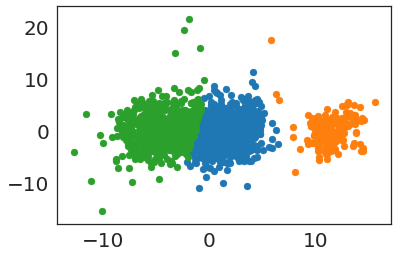

In [7]:
for n, color in enumerate(sns.color_palette(n_colors=3)):
    plt.scatter( transform[categories==n,0], transform[categories==n,1] , color=color)
plt.xlim()

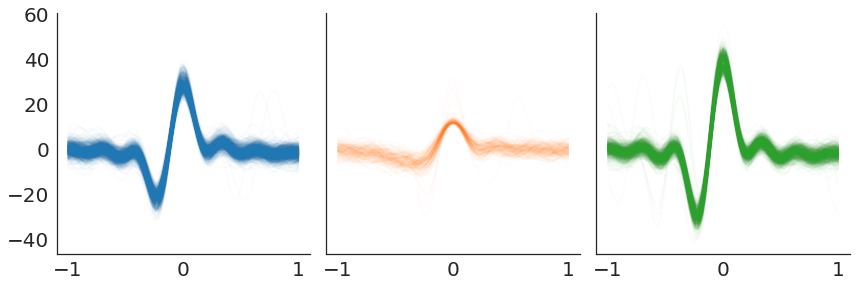

In [8]:
fig, axes = plt.subplots(1,3,figsize=(12,4),sharex=True,sharey=True)
for n, ax, color in zip(range(3), axes, sns.color_palette(n_colors=3)):
    ax.plot(epochs.times * 1e3, data[categories==n].T * 1e6, color=color, alpha=0.02)
    
sns.despine()
plt.tight_layout()

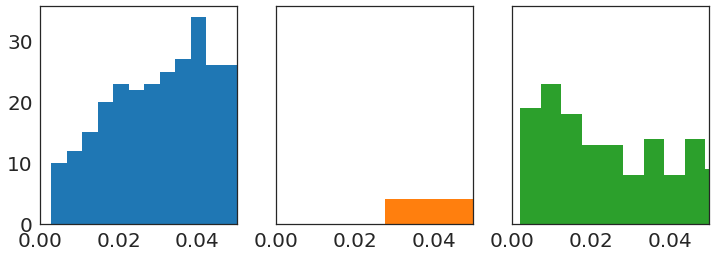

In [9]:
fig, axes = plt.subplots(1,3,figsize=(12,4),sharex=True,sharey=True)
for n, ax, color in zip(range(3),axes,sns.color_palette(n_colors=3)):
    d = np.diff( peak_times[categories==n] )
    ax.hist(d, bins=100, color=color)
    ax.set(xlim=(0,50e-3))

## References
1. Hill, D. N., Mehta, S. B., & Kleinfeld, D. (2011). Quality metrics to accompany spike sorting of extracellular signals. Journal of Neuroscience, 31(24), 8699-8705.
2. Quiroga, R. Q., Nadasdy, Z., & Ben-Shaul, Y. (2004). Unsupervised spike detection and sorting with wavelets and superparamagnetic clustering. Neural computation, 16(8), 1661-1687.
3. Rey, H. G., Pedreira, C., & Quiroga, R. Q. (2015). Past, present and future of spike sorting techniques. Brain research bulletin, 119, 106-117. Chicago.
